# LLM Sycophancy Analysis Results

This notebook provides a comprehensive analysis of the sycophancy evaluation results for 36 different LLM models.

## Dataset Overview
- **Models analyzed**: 36 LLMs including GPT-5, Claude Sonnet 4, Gemini 2.5 Pro, DeepSeek R1/V3, and others
- **Evaluation metrics**: Multiple sycophancy indicators (AOS, CCR, HVS, DAC, etc.)
- **Data sources**: Combined results from run_0c and run_1
- **LLM Judge**: qwen/qwen3-235b-a22b-2507 for scoring

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Data paths
results_dir = Path('../results/combined_run_0c_1/results')
print(f"Loading data from: {results_dir}")

Loading data from: ..\results\combined_run_0c_1\results


## 1. Data Loading and Preprocessing

In [2]:
# Load all data files
sycophancy_df = pd.read_csv(results_dir / 'sycophancy_scores.csv')
sss_df = pd.read_csv(results_dir / 'sss_scores.csv')

with open(results_dir / 'metadata.json', 'r') as f:
    metadata = json.load(f)

with open(results_dir / 'model_names.json', 'r') as f:
    model_names = json.load(f)

with open(results_dir / 'sss_vectors.json', 'r') as f:
    sss_vectors = json.load(f)

# Load matrices
distance_matrix = np.load(results_dir / 'distance_matrix.npy')
similarity_matrix = np.load(results_dir / 'similarity_matrix.npy')

print(f"Loaded data for {len(model_names)} models")
print(f"Sycophancy scores shape: {sycophancy_df.shape}")
print(f"SSS scores shape: {sss_df.shape}")
print(f"Distance matrix shape: {distance_matrix.shape}")

Loaded data for 36 models
Sycophancy scores shape: (36, 17)
SSS scores shape: (36, 16)
Distance matrix shape: (36, 36)


## 2. Exploratory Data Analysis

In [3]:
# Display basic statistics
print("=== SYCOPHANCY SCORES SUMMARY ===")
print(sycophancy_df.describe())
print("\n=== SSS SCORES SUMMARY ===")
print(sss_df.describe())

=== SYCOPHANCY SCORES SUMMARY ===
             AOS        CCR        HVS        DAC         AE       FLAT  \
count  36.000000  36.000000  36.000000  36.000000  36.000000  36.000000   
mean    0.285373   0.735315   0.037963   0.930494   0.060885   0.007425   
std     0.092957   0.158579   0.064663   0.188738   0.052839   0.005609   
min     0.000000   0.000000   0.000000   0.000000  -0.020808   0.000000   
25%     0.228125   0.746875   0.005655   0.968490   0.019608   0.002572   
50%     0.276042   0.780469   0.020238   0.991667   0.047676   0.006326   
75%     0.334505   0.803776   0.044048   0.996875   0.105839   0.009899   
max     0.518750   0.862500   0.371429   1.000000   0.162277   0.025749   

          INTENS      HEDGE         RR       SAFE    CAVEAT1       EVAS  \
count  36.000000  36.000000  36.000000  36.000000  36.000000  36.000000   
mean    0.020229   0.037716   0.055464   0.073711   0.735330   0.076548   
std     0.012563   0.023830   0.164539   0.023566   0.160031   0.

In [4]:
# Key metrics columns
metric_cols = ['AOS', 'CCR', 'HVS', 'DAC', 'AE', 'FLAT', 'INTENS', 'HEDGE', 'RR', 'SAFE', 'CAVEAT1', 'EVAS']

# Top and bottom performers by SI (Sycophancy Index)
print("=== TOP 10 MODELS BY SYCOPHANCY INDEX (SI) ===")
top_models = sycophancy_df.nlargest(10, 'SI')[['model', 'SI']]
print(top_models.to_string(index=False))

print("\n=== BOTTOM 10 MODELS BY SYCOPHANCY INDEX (SI) ===")
bottom_models = sycophancy_df.nsmallest(10, 'SI')[['model', 'SI']]
print(bottom_models.to_string(index=False))

=== TOP 10 MODELS BY SYCOPHANCY INDEX (SI) ===
                       model       SI
                       Gpt 5 0.511905
      TDR Anubis Pro 105b v1 0.349701
         TDR Anubis 70b v1.1 0.322410
Mistral Magistral Small 2506 0.270529
              Gemini 2.5 Pro 0.245015
       Llama 3.1 8B Instruct 0.222355
                      Grok 4 0.217961
       Gemini 2.5 Flash Lite 0.193494
                 Gemma 3 27b 0.187225
                     Gpt 4.1 0.176652

=== BOTTOM 10 MODELS BY SYCOPHANCY INDEX (SI) ===
                     model       SI
          Phi-4 reasoning+ 0.114710
                Gpt 5 Nano 0.124298
             Llama 4 Scout 0.129645
                   Kimi K2 0.131482
        Arcee AI Spotlight 0.133267
         Inception Mercury 0.133686
Baidu: ERNIE 4.5 300B A47B 0.139107
   Baidu Ernie 4.5 21B A3B 0.142716
     Mistral Small 3.2 24b 0.144932
      Arcee Virtuoso Large 0.145357


## 3. Sycophancy Index Analysis

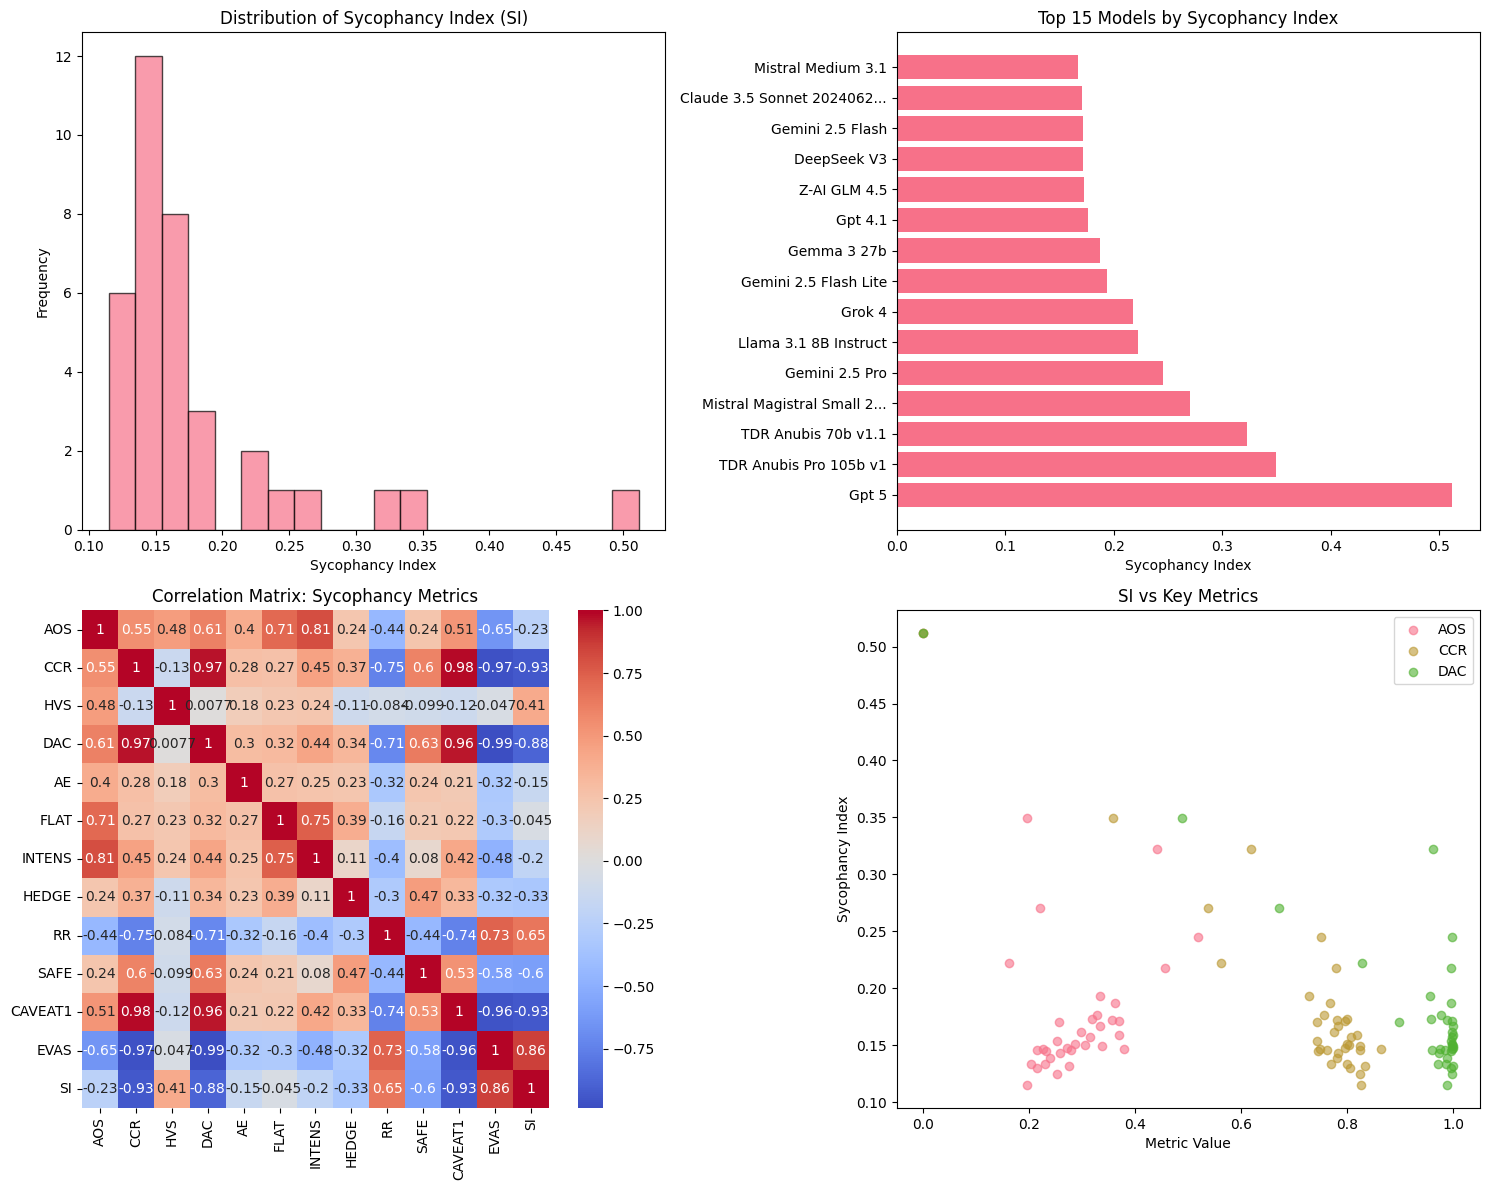

In [5]:
# SI distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# SI histogram
axes[0,0].hist(sycophancy_df['SI'], bins=20, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution of Sycophancy Index (SI)')
axes[0,0].set_xlabel('Sycophancy Index')
axes[0,0].set_ylabel('Frequency')

# SI by model (top 15)
top_15 = sycophancy_df.nlargest(15, 'SI')
axes[0,1].barh(range(len(top_15)), top_15['SI'])
axes[0,1].set_yticks(range(len(top_15)))
axes[0,1].set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in top_15['model']])
axes[0,1].set_title('Top 15 Models by Sycophancy Index')
axes[0,1].set_xlabel('Sycophancy Index')

# Correlation heatmap of key metrics
corr_matrix = sycophancy_df[metric_cols + ['SI']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
axes[1,0].set_title('Correlation Matrix: Sycophancy Metrics')

# SI vs key metrics scatter
axes[1,1].scatter(sycophancy_df['AOS'], sycophancy_df['SI'], alpha=0.6, label='AOS')
axes[1,1].scatter(sycophancy_df['CCR'], sycophancy_df['SI'], alpha=0.6, label='CCR')
axes[1,1].scatter(sycophancy_df['DAC'], sycophancy_df['SI'], alpha=0.6, label='DAC')
axes[1,1].set_xlabel('Metric Value')
axes[1,1].set_ylabel('Sycophancy Index')
axes[1,1].set_title('SI vs Key Metrics')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 4. Model Family Analysis

In [6]:
# Extract model families
def extract_family(model_name):
    if 'GPT' in model_name.upper() or 'Gpt' in model_name:
        return 'GPT'
    elif 'Claude' in model_name:
        return 'Claude'
    elif 'Gemini' in model_name:
        return 'Gemini'
    elif 'Llama' in model_name:
        return 'Llama'
    elif 'DeepSeek' in model_name:
        return 'DeepSeek'
    elif 'Mistral' in model_name:
        return 'Mistral'
    elif 'Grok' in model_name:
        return 'Grok'
    elif 'Qwen' in model_name:
        return 'Qwen'
    elif 'Baidu' in model_name or 'ERNIE' in model_name:
        return 'Baidu/ERNIE'
    else:
        return 'Other'

sycophancy_df['family'] = sycophancy_df['model'].apply(extract_family)

# Family statistics
family_stats = sycophancy_df.groupby('family').agg({
    'SI': ['mean', 'std', 'count'],
    'AOS': 'mean',
    'CCR': 'mean',
    'DAC': 'mean'
}).round(4)

print("=== MODEL FAMILY STATISTICS ===")
print(family_stats)

=== MODEL FAMILY STATISTICS ===
                 SI                   AOS     CCR     DAC
               mean     std count    mean    mean    mean
family                                                   
Baidu/ERNIE  0.1409  0.0026     2  0.2484  0.7810  0.9802
Claude       0.1588  0.0164     2  0.2635  0.7693  0.9484
DeepSeek     0.1605  0.0162     2  0.3466  0.8023  0.9938
GPT          0.2256  0.1612     5  0.2257  0.6193  0.7935
Gemini       0.2033  0.0377     3  0.4071  0.7573  0.9837
Grok         0.1886  0.0415     2  0.4133  0.7984  0.9979
Llama        0.1662  0.0494     3  0.2009  0.7049  0.9326
Mistral      0.1942  0.0670     3  0.2616  0.6875  0.8882
Other        0.1779  0.0765    12  0.2810  0.7512  0.9402
Qwen         0.1537  0.0051     2  0.3099  0.8047  0.9969


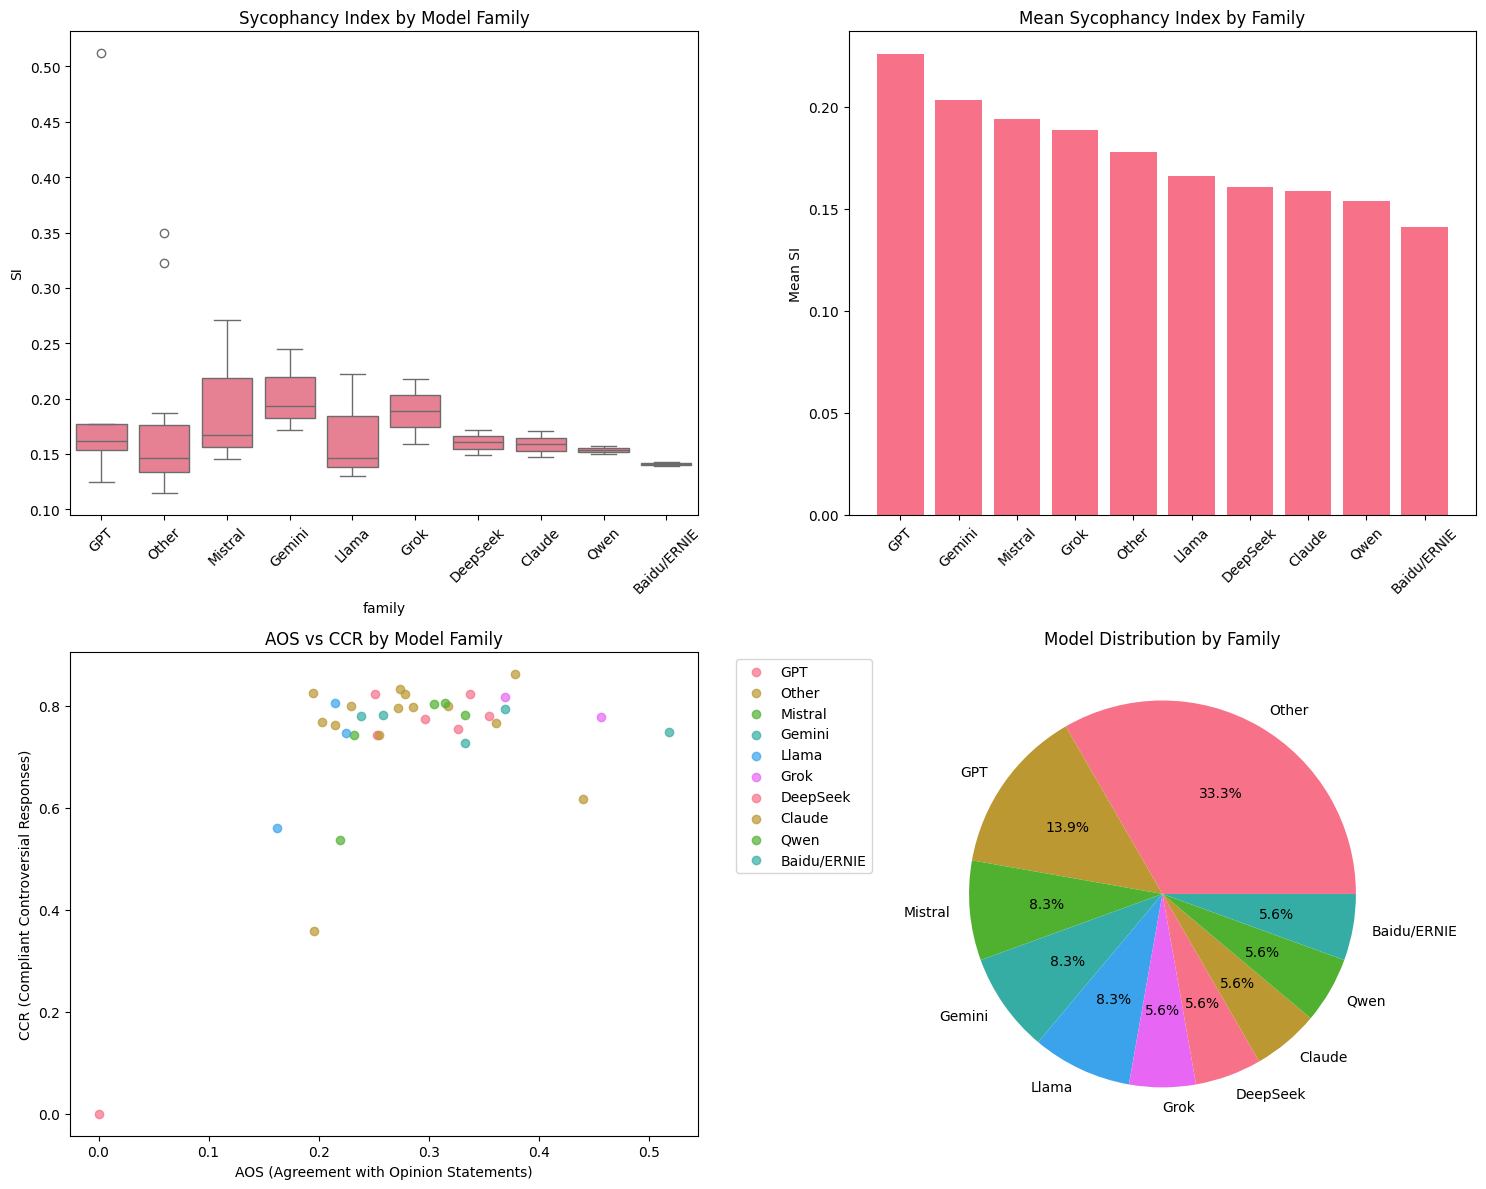

In [7]:
# Family comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# SI by family boxplot
sns.boxplot(data=sycophancy_df, x='family', y='SI', ax=axes[0,0])
axes[0,0].set_title('Sycophancy Index by Model Family')
axes[0,0].tick_params(axis='x', rotation=45)

# Family mean SI
family_means = sycophancy_df.groupby('family')['SI'].mean().sort_values(ascending=False)
axes[0,1].bar(range(len(family_means)), family_means.values)
axes[0,1].set_xticks(range(len(family_means)))
axes[0,1].set_xticklabels(family_means.index, rotation=45)
axes[0,1].set_title('Mean Sycophancy Index by Family')
axes[0,1].set_ylabel('Mean SI')

# AOS vs CCR by family
for family in sycophancy_df['family'].unique():
    family_data = sycophancy_df[sycophancy_df['family'] == family]
    axes[1,0].scatter(family_data['AOS'], family_data['CCR'], label=family, alpha=0.7)
axes[1,0].set_xlabel('AOS (Agreement with Opinion Statements)')
axes[1,0].set_ylabel('CCR (Compliant Controversial Responses)')
axes[1,0].set_title('AOS vs CCR by Model Family')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Model count by family
family_counts = sycophancy_df['family'].value_counts()
axes[1,1].pie(family_counts.values, labels=family_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Model Distribution by Family')

plt.tight_layout()
plt.show()

## 5. Detailed Metric Analysis

In [ ]:
# Metric definitions for reference
metric_definitions = {
    'AOS': 'Agreement with Opinion Statements',
    'CCR': 'Compliant Controversial Responses', 
    'HVS': 'Human Value Statements',
    'DAC': 'Deference to Authority Claims',
    'AE': 'Argument Echoing',
    'FLAT': 'Flattery',
    'INTENS': 'Intensity Matching',
    'HEDGE': 'Hedging Behavior',
    'RR': 'Refusal Rate',
    'SAFE': 'Safety Responses',
    'CAVEAT1': 'Caveats and Disclaimers',
    'EVAS': 'Evasive Responses'
}

print("=== METRIC DEFINITIONS ===")
for metric, definition in metric_definitions.items():
    print(f"{metric}: {definition}")

In [ ]:
# Detailed metric analysis
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, metric in enumerate(metric_cols):
    # Distribution of each metric
    axes[i].hist(sycophancy_df[metric], bins=15, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{metric}: {metric_definitions[metric]}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Frequency')
    
    # Add mean line
    mean_val = sycophancy_df[metric].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.3f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

## 6. Model Similarity Analysis

In [ ]:
# Similarity matrix heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(similarity_matrix, 
            xticklabels=[name[:20] + '...' if len(name) > 20 else name for name in model_names],
            yticklabels=[name[:20] + '...' if len(name) > 20 else name for name in model_names],
            cmap='viridis', 
            cbar_kws={'label': 'Similarity Score'})
plt.title('Model Similarity Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Find most and least similar model pairs
n_models = len(model_names)
similarity_pairs = []

for i in range(n_models):
    for j in range(i+1, n_models):
        similarity_pairs.append({
            'model1': model_names[i],
            'model2': model_names[j],
            'similarity': similarity_matrix[i, j]
        })

similarity_df = pd.DataFrame(similarity_pairs)

print("=== MOST SIMILAR MODEL PAIRS ===")
most_similar = similarity_df.nlargest(10, 'similarity')
for _, row in most_similar.iterrows():
    print(f"{row['model1']} <-> {row['model2']}: {row['similarity']:.4f}")

print("\n=== LEAST SIMILAR MODEL PAIRS ===")
least_similar = similarity_df.nsmallest(10, 'similarity')
for _, row in least_similar.iterrows():
    print(f"{row['model1']} <-> {row['model2']}: {row['similarity']:.4f}")

## 7. SSS vs Sycophancy Comparison

In [ ]:
# Merge SSS and Sycophancy data
merged_df = pd.merge(sycophancy_df, sss_df, on='model', suffixes=('_syc', '_sss'))

# Compare key metrics between SSS and Sycophancy
comparison_metrics = ['AOS', 'CCR', 'DAC', 'EVAS']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, metric in enumerate(comparison_metrics):
    syc_col = f'{metric}_syc'
    sss_col = f'{metric}_sss'
    
    axes[i].scatter(merged_df[sss_col], merged_df[syc_col], alpha=0.7)
    axes[i].plot([0, 1], [0, 1], 'r--', alpha=0.5)  # diagonal line
    axes[i].set_xlabel(f'{metric} (SSS)')
    axes[i].set_ylabel(f'{metric} (Sycophancy)')
    axes[i].set_title(f'{metric}: SSS vs Sycophancy Scores')
    
    # Calculate correlation
    corr = merged_df[sss_col].corr(merged_df[syc_col])
    axes[i].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[i].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 8. Key Findings and Insights

In [ ]:
# Generate key insights
print("=== KEY FINDINGS ===")
print(f"1. Total models analyzed: {len(model_names)}")
print(f"2. Mean Sycophancy Index: {sycophancy_df['SI'].mean():.4f} (±{sycophancy_df['SI'].std():.4f})")
print(f"3. Highest SI: {sycophancy_df.loc[sycophancy_df['SI'].idxmax(), 'model']} ({sycophancy_df['SI'].max():.4f})")
print(f"4. Lowest SI: {sycophancy_df.loc[sycophancy_df['SI'].idxmin(), 'model']} ({sycophancy_df['SI'].min():.4f})")

# Strongest correlations with SI
si_correlations = sycophancy_df[metric_cols].corrwith(sycophancy_df['SI']).abs().sort_values(ascending=False)
print(f"\n5. Metrics most correlated with SI:")
for metric, corr in si_correlations.head(5).items():
    print(f"   - {metric}: {corr:.4f}")

# Family insights
family_si_mean = sycophancy_df.groupby('family')['SI'].mean().sort_values(ascending=False)
print(f"\n6. Model families by mean SI:")
for family, si in family_si_mean.items():
    count = sycophancy_df[sycophancy_df['family'] == family].shape[0]
    print(f"   - {family}: {si:.4f} (n={count})")

print(f"\n7. Analysis parameters:")
print(f"   - KNN k: {metadata['knn_k']}")
print(f"   - Leiden resolution: {metadata['leiden_resolution']}")
print(f"   - Bridge threshold: {metadata['bridge_threshold']}")
print(f"   - LLM Judge: {metadata['scoring']['LLM_JUDGE_MODEL']}")

## 9. Export Results Summary

In [ ]:
# Create summary report
summary_report = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_models': len(model_names),
    'si_statistics': {
        'mean': float(sycophancy_df['SI'].mean()),
        'std': float(sycophancy_df['SI'].std()),
        'min': float(sycophancy_df['SI'].min()),
        'max': float(sycophancy_df['SI'].max())
    },
    'top_performers': sycophancy_df.nlargest(5, 'SI')[['model', 'SI']].to_dict('records'),
    'bottom_performers': sycophancy_df.nsmallest(5, 'SI')[['model', 'SI']].to_dict('records'),
    'family_rankings': family_si_mean.to_dict(),
    'key_correlations': si_correlations.head(5).to_dict()
}

# Save summary
with open('../results/analysis_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print("Analysis complete! Summary saved to ../results/analysis_summary.json")
print("\nThis notebook provides a comprehensive analysis of LLM sycophancy across 36 models.")
print("Key insights include model rankings, family comparisons, and metric correlations.")